In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cmocean

In [2]:
Y_sim = np.load('greenland_ff_3611.npy', mmap_mode='r').T
print(Y_sim.shape)
t_sim = np.loadtxt('../../expdesign/greenland_train_standard.csv',
    delimiter=',', skiprows=1)
Y_test = np.load('../test/greenland_ff_3611.npy', mmap_mode='r').T
t_test = np.loadtxt('../../expdesign/greenland_test_standard.csv',
    delimiter=',', skiprows=1)

(512, 365)


In [3]:
sim_num = 90
node = 3611

(128, 15)
var_train: 0.9799906679050052
var_test: 0.9738905358458219
(256, 15)
var_train: 0.9792940840691476
var_test: 0.9766799378784411
(512, 15)
var_train: 0.9787890313051548
var_test: 0.9773663831951628


(120.0, 300.0)

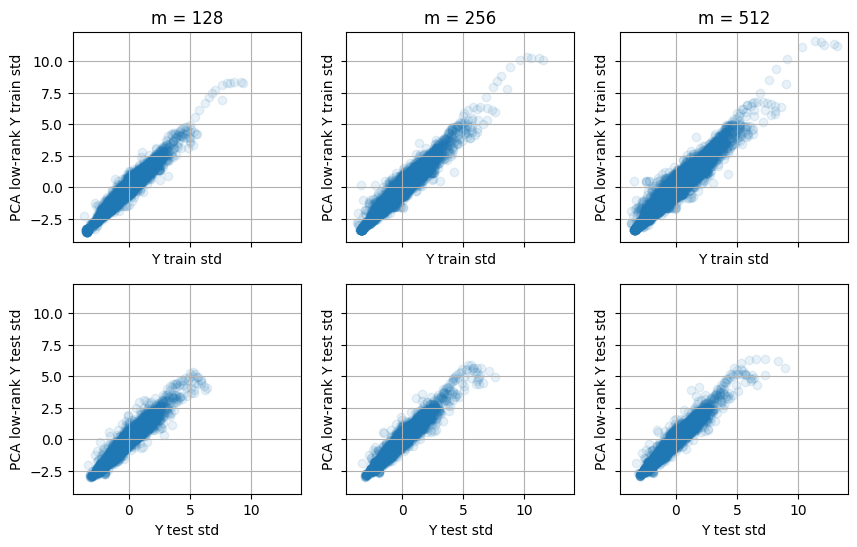

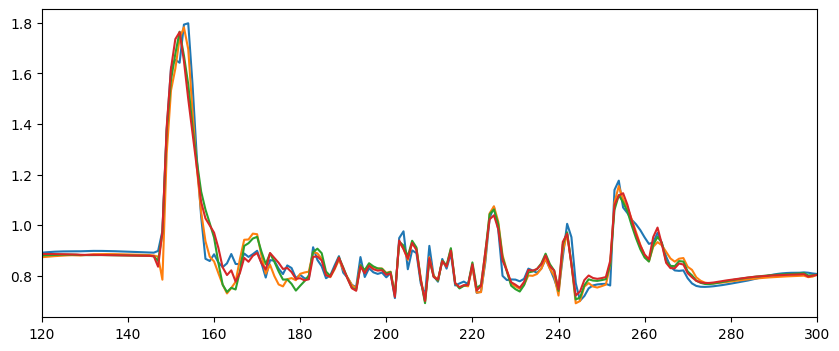

In [4]:
ms = [128, 256, 512]
p = 15
fig,axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=3, sharey=True, sharex=True)
yfig,yax = plt.subplots(figsize=(10, 4))
yax.plot(Y_test[90])
W_train = []
W_test = []
dY = []
for i in range(len(ms)):
# for i in range(1):
    mi = ms[i]
    mu = np.mean(Y_sim[:mi], axis=0)
    sd = np.std(Y_sim[:mi], axis=0)
    yi = (Y_sim[:mi]-mu)/sd
    zi = (Y_test-mu)/sd
    u,s,vh = np.linalg.svd(yi, full_matrices=False)
    K = np.diag(s[:p]) @ vh[:p] / np.sqrt(365)
    
    W = np.sqrt(365) * u[:, :p]
    print(W.shape)

    Sinv = np.diag(1/s[:p])
    
    wi_test = zi @ K.T @ Sinv**2 * 365
    wi_train = yi @ K.T @ Sinv**2 * 365
    
    W_test.append(wi_test)

    W_train.append(wi_train)

    Y_test_recons = wi_test @ K
    Y_train_recons = wi_train @ K
    
    # What about the PCA representation of the data?
    yerr = Y_test - (mu + sd*Y_test_recons)
    rmse = np.sqrt(np.mean(yerr**2, axis=0))
    dY.append(rmse)
    
    yax.plot(mu + sd*Y_test_recons[90])

#     fig,ax = plt.subplots()
#     ax.scatter(W.flatten(), W_train.flatten())
    ax = axs[0,i]
    ax.scatter(yi.flatten(), Y_train_recons.flatten(), alpha=0.1)
    ax.set_xlabel('Y train std')
    ax.set_ylabel('PCA low-rank Y train std')
    ax.grid()
    ax.set_title('m = {}'.format(mi))
    
    var_train = 1 - np.mean((yi - Y_train_recons)**2)/np.var(yi)
    print('var_train:', var_train)
    
    var_test = 1 - np.mean((zi - Y_test_recons)**2)/np.var(zi)
    print('var_test:', var_test)

    ax = axs[1,i]
    ax.scatter(zi.flatten(), Y_test_recons.flatten(), alpha=0.1)
    ax.set_xlabel('Y test std')
    ax.set_ylabel('PCA low-rank Y test std')
    ax.grid()

yax.set_xlim([120, 300])

77


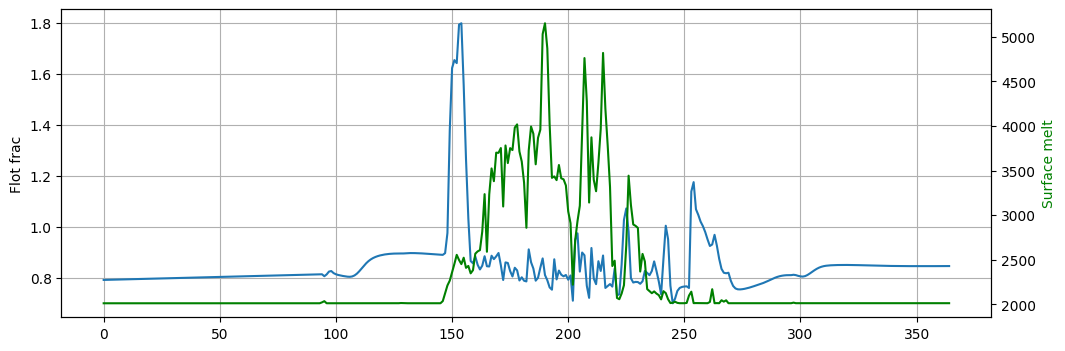

In [5]:
fig,ax = plt.subplots(figsize=(12, 4))
ax.plot(Y_test[90])

moulins = np.load('../data/yang2016_moulins/moulins_catchments_YS16.pkl', allow_pickle=True)
indices = [moulin['moulin'] for moulin in moulins]
mesh = np.load('../data/geom/IS_mesh.pkl', allow_pickle=True)
moulinx = mesh['x'][indices]
mouliny = mesh['y'][indices]
moulindist = np.sqrt(
    (moulinx - mesh['x'][node])**2 + (mouliny - mesh['y'][node])**2
)
near_moulin = np.argmin(moulindist)
print(near_moulin)
# mxy = [(moulin['x'], moulin['y']) for moulin in moulins]


melt = np.load('../data/melt/basin_integrated_inputs_RACMO.npy')
melt_sum = np.sum(melt, axis=0)
# melt_sum = melt[near_moulin]
ax2 = ax.twinx()
ax2.plot(melt_sum[-365:], color='g')
ax2.set_ylabel('Surface melt', color='g')
ax.set_ylabel('Flot frac')
ax.grid()

77


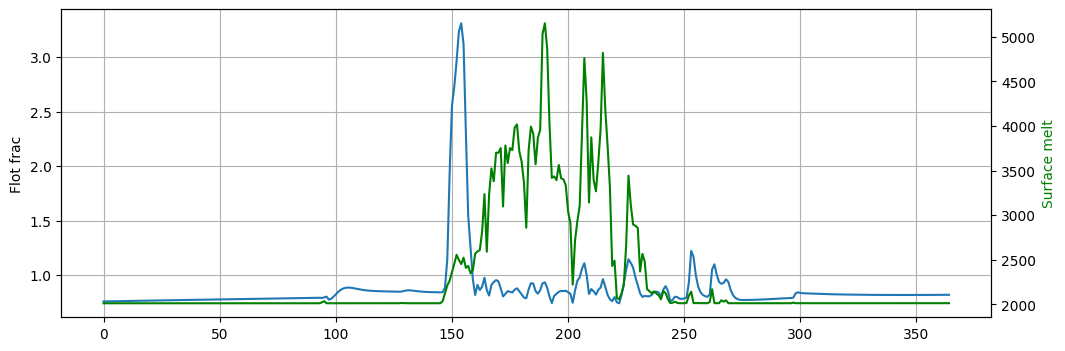

In [6]:
fig,ax = plt.subplots(figsize=(12, 4))
ax.plot(Y_test[32])

moulins = np.load('../data/yang2016_moulins/moulins_catchments_YS16.pkl', allow_pickle=True)
indices = [moulin['moulin'] for moulin in moulins]
mesh = np.load('../data/geom/IS_mesh.pkl', allow_pickle=True)
moulinx = mesh['x'][indices]
mouliny = mesh['y'][indices]
moulindist = np.sqrt(
    (moulinx - mesh['x'][node])**2 + (mouliny - mesh['y'][node])**2
)
near_moulin = np.argmin(moulindist)
print(near_moulin)
# mxy = [(moulin['x'], moulin['y']) for moulin in moulins]


melt = np.load('../data/melt/basin_integrated_inputs_RACMO.npy')
melt_sum = np.sum(melt, axis=0)
# melt_sum = melt[near_moulin]
ax2 = ax.twinx()
ax2.plot(melt_sum[-365:], color='g')
ax2.set_ylabel('Surface melt', color='g')
ax.set_ylabel('Flot frac')
ax.grid()

(100, 128)
1.0023712319439153
(100, 256)
0.6494228888406877
(100, 512)
0.41698761202035883


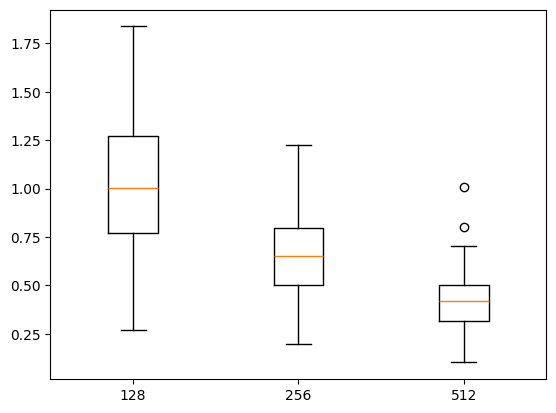

In [7]:
fig,ax = plt.subplots()
dws = []
for i in range(3):
#     dw_test_train = np.linalg.norm(W_train[i][None,:,:] - W_test[i][:,None,:], axis=-1)#/np.sqrt(365)
    dw_test_train = np.sqrt(np.mean((W_train[i][None,:,:] - W_test[i][:,None,:])**2, axis=-1))
    print(dw_test_train.shape)
    
#     dw_max = np.linalg.norm(dw_test_train, axis=1)/np.sqrt(ms[i])
#     dw_max = np.sqrt(np.mean(dw_test_train**2, axis=1))
    dw_max = np.min(dw_test_train, axis=1)
    dws.append(dw_max)
    print(np.median(dw_max))

ax.boxplot(dws)
ax.set_xticks(np.arange(1,4), ms)

0.41698761202035883
0.4201486180653535


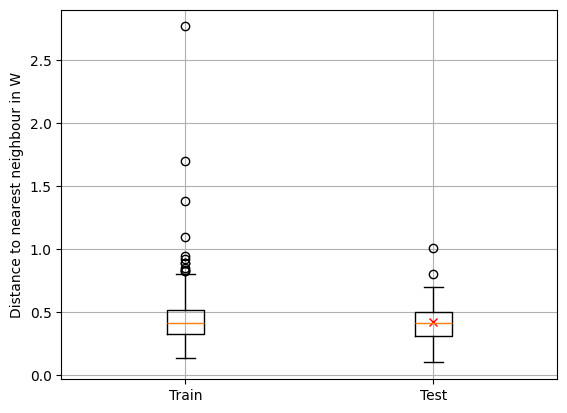

In [8]:
dw_train = np.sqrt(np.mean((W_train[i][None,:,:] - W_train[i][:,None,:])**2, axis=-1))
np.fill_diagonal(dw_train, np.nan)

dw_test = dws[-1]
# dw_all_test = np.nanmin(dw_test, axis=0)
dw_train = np.nanmin(dw_train, axis=0)

fig,ax = plt.subplots()
ax.boxplot((dw_train, dw_test))
ax.set_xticks((1,2), ('Train', 'Test'))
ax.set_ylabel(r'Distance to nearest neighbour in W')
ax.plot(2, dw_test[90], 'rx')
ax.grid()

print(np.median(dw_test))
print(dw_test[90])

0.008862592709209534
0.009124673316048004
0.008759189884670764


Text(0.5, 0, 'Number of training runs')

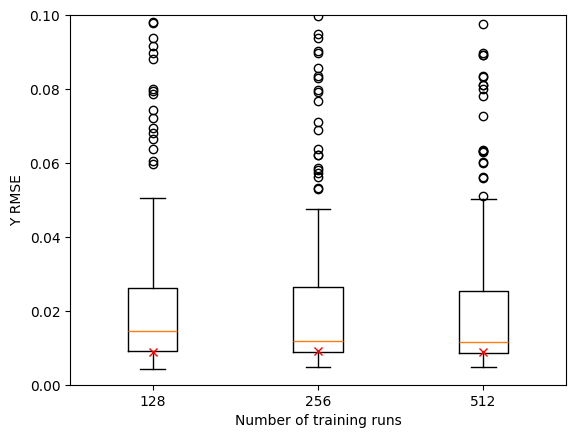

In [9]:
fig,ax = plt.subplots()
ax.boxplot(dY)
for i in range(3):
    ax.plot(i+1, dY[i][90], 'rx')
    print(dY[i][90])
ax.set_ylim([0, 0.1])
ax.set_ylabel('Y RMSE')
ax.set_xticks(1+np.arange(3), ms)
ax.set_xlabel('Number of training runs')
    

In [37]:
err = (Y_test[90:91]-mu)/sd - Y_train_recons
print(err.shape)
sigma = np.sqrt(0.03)
likeli = np.exp(-0.5*np.mean(err**2, axis=1)/sigma**2)
print(likeli.shape)
likeli = likeli/np.sum(likeli)
m = 512

t_names = np.loadtxt('../../expdesign/greenland_train_standard.csv', delimiter=',', max_rows=1, dtype=str)[:m]

t_sim = np.loadtxt('../../expdesign/greenland_train_standard.csv',
    delimiter=',', skiprows=1)
t_test = np.loadtxt('../../expdesign/greenland_test_standard.csv',
    delimiter=',', skiprows=1)

(512, 365)
(512,)


Most likely para:
[0.1677311 0.4375043 0.4528795 0.7036287 0.6432509 0.6422678 0.9489434
 0.5413216]
True para:
[0.745 0.685 0.275 0.735 0.195 0.735 0.765 0.745]
lmax: 0.05348184605610287


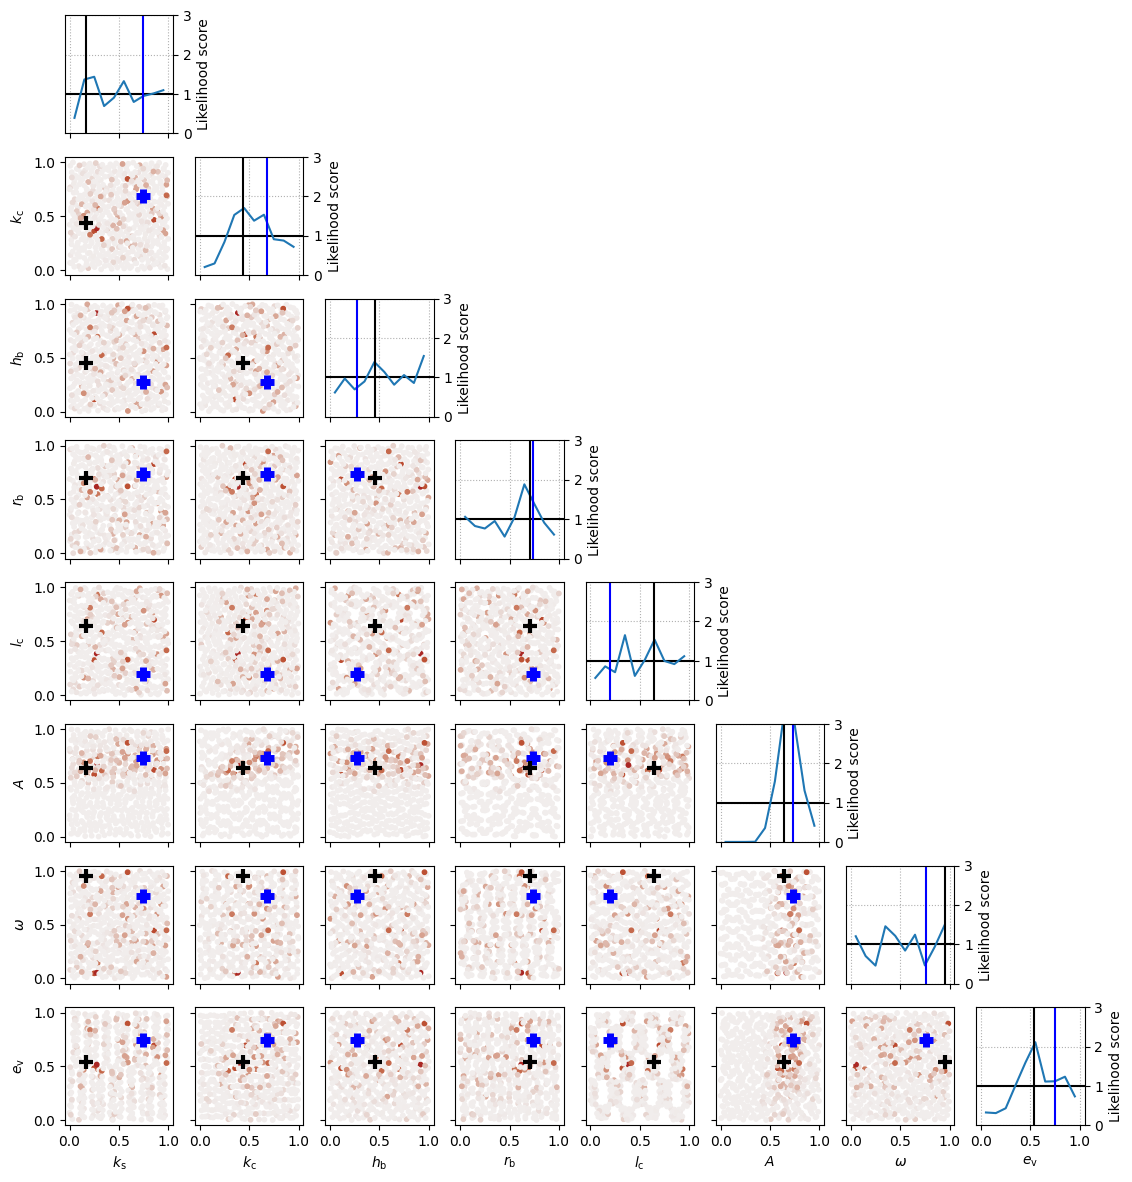

In [41]:
# t_sim = np.loadtxt('../issm/expdesign/greenland_train_standard.csv', delimiter=',', skiprows=1)[:m]
m = 512

print('Most likely para:')
ix = np.argmax(likeli)
print(t_sim[ix])
print('True para:')
print(t_test[sim_num])

t_names = np.loadtxt('../../expdesign/greenland_train_standard.csv', delimiter=',', max_rows=1, dtype=str)[:m]
fig,ax = plt.subplots(8,8,figsize=(12,12), sharex=True, sharey=False)
lmax = np.max(likeli)
print('lmax:', lmax)
dt = 0.1
thetas = np.arange(0, 1+dt, dt)
marginals = np.zeros((len(t_names), len(thetas)-1))
for i in range(len(t_names)):
    for j in range(len(thetas)-1):
        tmask = np.logical_and(t_sim[:,i]>=thetas[j], t_sim[:,i]<thetas[j+1])
#         print(len(np.where(tmask)[0]))
        marginals[i, j] = np.mean(likeli[tmask])

marginals = marginals/np.vstack(np.sum(marginals*dt, axis=1))
        
for axi in ax.flat:
    axi.set_visible(False)
for row in range(8):
    for col in range(row):
        ax[row,col].set_visible(True)
        sc = ax[row,col].scatter(t_sim[:,col], t_sim[:,row], 10, likeli, vmin=0, vmax=lmax, cmap=cmocean.cm.amp)
#         ax[row,col].axvline(t_test[sim_num, col], color='b')
        ax[row,col].plot(t_test[sim_num,col], t_test[sim_num,row], 'b+',
            markersize=10, markeredgewidth=5)
        ax[row,col].plot(t_sim[ix,col], t_sim[ix,row], 'k+',
            markersize=10, markeredgewidth=3)
        # print((row+1, col))
        if col==0:
            ax[row,col].set_ylabel(t_names[row])
        elif row!=col:
            ax[row,col].set_yticklabels([])
        if row==7:
            ax[row,col].set_xlabel(t_names[col])

    ax[row,row].set_visible(True)
    ax[row,row].axhline(1., color='k', label='prior')
    ax[row,row].plot(thetas[:-1] + 0.5*dt, marginals[row], label='posterior')
    # ax[row,row].set_ylim([0, 0.005])
    ax[row,row].set_ylim([0,3])
    ax[row,row].yaxis.tick_right()
    ax[row,row].yaxis.set_label_position('right')
    ax[row,row].set_ylabel('Likelihood score')
    ax[row,row].grid(linestyle=':')
    ax[row,row].set_xticks(np.linspace(0,1,3))
#     ax[row,row].plot(t_test)
    ax[row,row].axvline(t_test[sim_num, row], color='b')
    ax[row,row].axvline(t_sim[ix,row], color='k')

ax[-1,-1].set_xlabel(t_names[-1])

plt.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.975)
# fig.savefig('likelihood_weighting_m512.png', dpi=300)
# fig.savefig('likelihood_weighting_prototype_para_dist_synthetic.png', dpi=300)

## What do the PCs look like?

(512,)


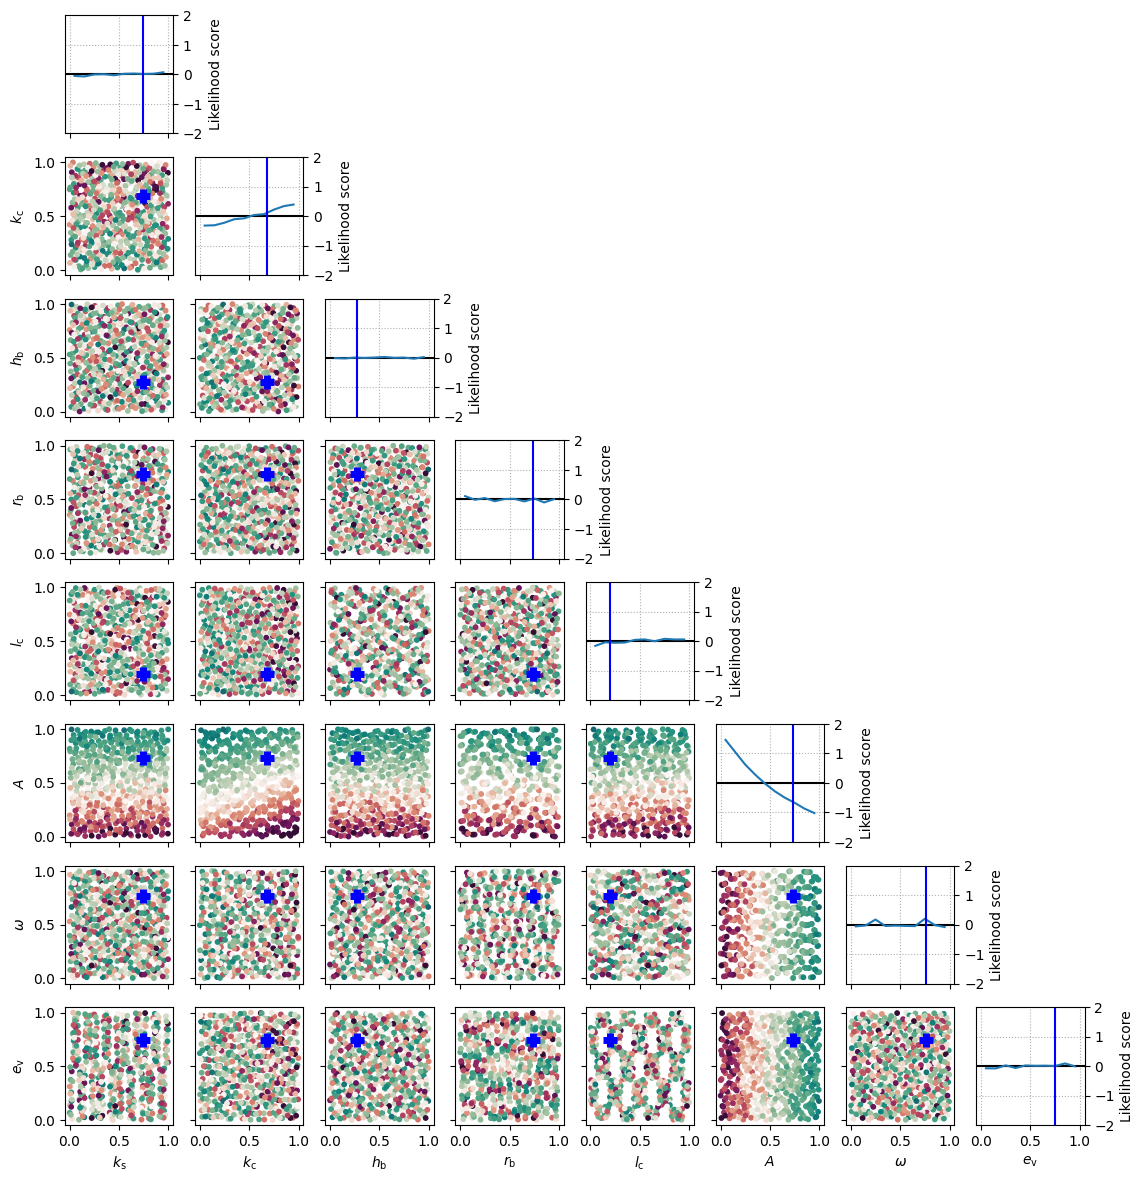

In [25]:
# t_sim = np.loadtxt('../issm/expdesign/greenland_train_standard.csv', delimiter=',', skiprows=1)[:m]
m = 512
t_names = np.loadtxt('../../expdesign/greenland_train_standard.csv', delimiter=',', max_rows=1, dtype=str)[:m]
fig,ax = plt.subplots(8,8,figsize=(12,12), sharex=True, sharey=False)
lmax = np.max(likeli)
dt = 0.1
thetas = np.arange(0, 1+dt, dt)
marginals = np.zeros((len(t_names), len(thetas)-1))
for i in range(len(t_names)):
    for j in range(len(thetas)-1):
        tmask = np.logical_and(t_sim[:,i]>=thetas[j], t_sim[:,i]<thetas[j+1])
#         print(len(np.where(tmask)[0]))
        wi = W_train[-1][:, 0]
        marginals[i, j] = np.mean(W_train[-1][:, 0][tmask])
print(wi.shape)

# marginals = marginals/np.vstack(np.sum(marginals*dt, axis=1))
        
for axi in ax.flat:
    axi.set_visible(False)
for row in range(8):
    for col in range(row):
        ax[row,col].set_visible(True)
        sc = ax[row,col].scatter(t_sim[:,col], t_sim[:,row], 10, W_train[-1][:, 0], vmin=-2, vmax=2, cmap=cmocean.cm.curl)
#         ax[row,col].axvline(t_test[sim_num, col], color='b')
        ax[row,col].plot(t_test[sim_num,col], t_test[sim_num,row], 'b+',
            markersize=10, markeredgewidth=5)
        # print((row+1, col))
        if col==0:
            ax[row,col].set_ylabel(t_names[row])
        elif row!=col:
            ax[row,col].set_yticklabels([])
        if row==7:
            ax[row,col].set_xlabel(t_names[col])

    ax[row,row].set_visible(True)
    ax[row,row].axhline(0., color='k', label='prior')
    ax[row,row].plot(thetas[:-1] + 0.5*dt, marginals[row], label='posterior')
    # ax[row,row].set_ylim([0, 0.005])
    ax[row,row].set_ylim([-2, 2])
    ax[row,row].yaxis.tick_right()
    ax[row,row].yaxis.set_label_position('right')
    ax[row,row].set_ylabel('Likelihood score')
    ax[row,row].grid(linestyle=':')
    ax[row,row].set_xticks(np.linspace(0,1,3))
#     ax[row,row].plot(t_test)
    ax[row,row].axvline(t_test[sim_num, row], color='b')

ax[-1,-1].set_xlabel(t_names[-1])

plt.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.975)
# fig.savefig('likelihood_weighting_m512.png', dpi=300)
# fig.savefig('likelihood_weighting_prototype_para_dist_synthetic.png', dpi=300)

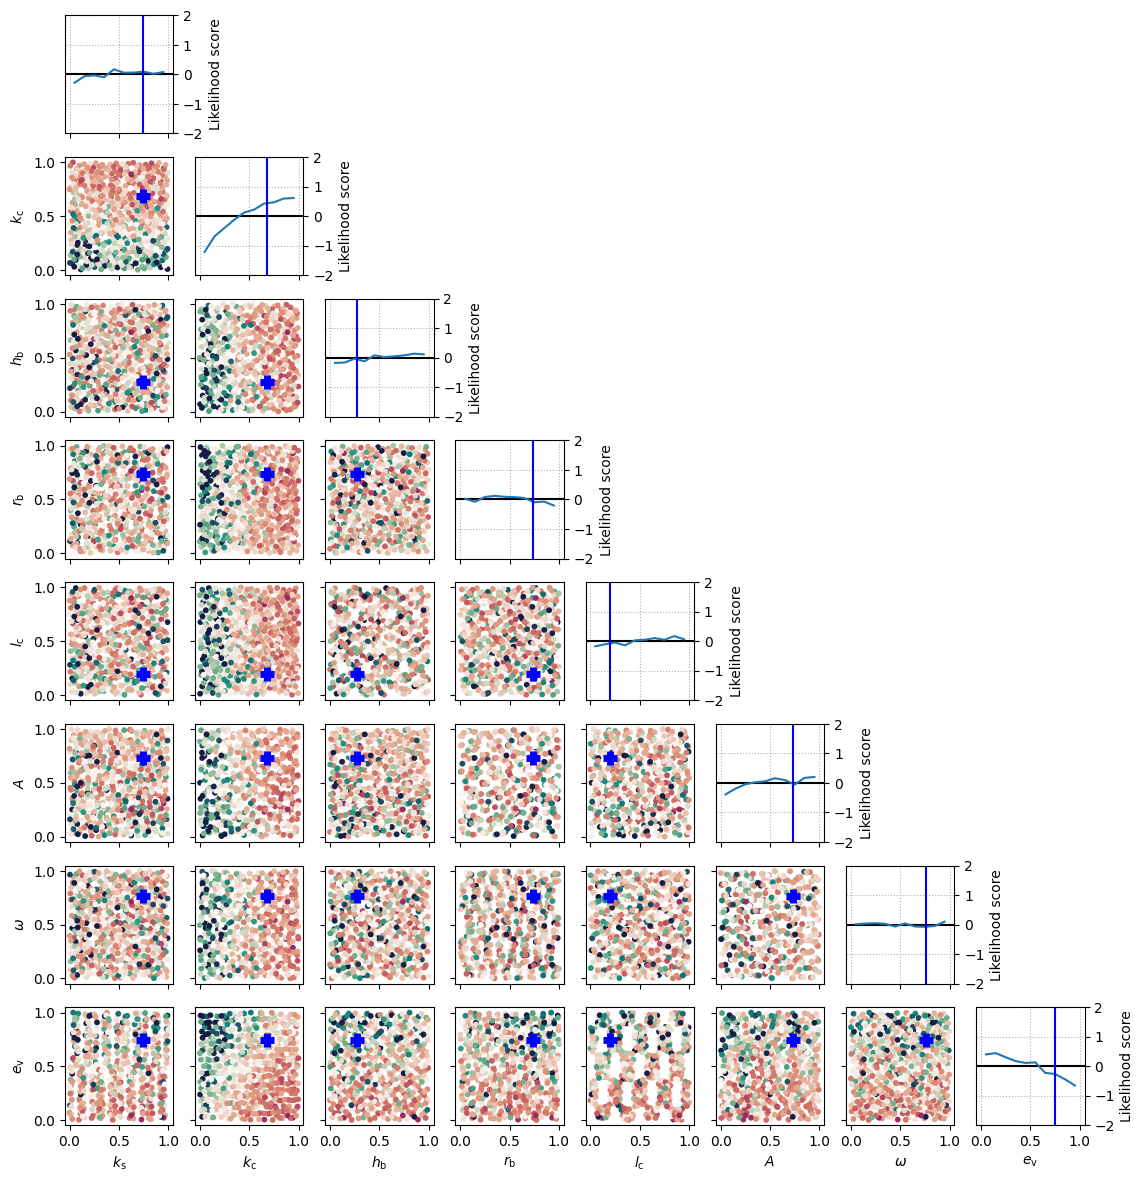

In [23]:
# t_sim = np.loadtxt('../issm/expdesign/greenland_train_standard.csv', delimiter=',', skiprows=1)[:m]
m = 512
t_names = np.loadtxt('../../expdesign/greenland_train_standard.csv', delimiter=',', max_rows=1, dtype=str)[:m]
fig,ax = plt.subplots(8,8,figsize=(12,12), sharex=True, sharey=False)
lmax = np.max(likeli)
dt = 0.1
thetas = np.arange(0, 1+dt, dt)
marginals = np.zeros((len(t_names), len(thetas)-1))
wi = W_train[-1][:, 1]
for i in range(len(t_names)):
    for j in range(len(thetas)-1):
        tmask = np.logical_and(t_sim[:,i]>=thetas[j], t_sim[:,i]<thetas[j+1])
#         print(len(np.where(tmask)[0]))
        wi = W_train[-1][:, 1]
        marginals[i, j] = np.mean(wi[tmask])

# marginals = marginals/np.vstack(np.sum(marginals*dt, axis=1))
        
for axi in ax.flat:
    axi.set_visible(False)
for row in range(8):
    for col in range(row):
        ax[row,col].set_visible(True)
        sc = ax[row,col].scatter(t_sim[:,col], t_sim[:,row], 10, wi, vmin=-2, vmax=2, cmap=cmocean.cm.curl)
#         ax[row,col].axvline(t_test[sim_num, col], color='b')
        ax[row,col].plot(t_test[sim_num,col], t_test[sim_num,row], 'b+',
            markersize=10, markeredgewidth=5)
        # print((row+1, col))
        if col==0:
            ax[row,col].set_ylabel(t_names[row])
        elif row!=col:
            ax[row,col].set_yticklabels([])
        if row==7:
            ax[row,col].set_xlabel(t_names[col])

    ax[row,row].set_visible(True)
    ax[row,row].axhline(0., color='k', label='prior')
    ax[row,row].plot(thetas[:-1] + 0.5*dt, marginals[row], label='posterior')
    # ax[row,row].set_ylim([0, 0.005])
    ax[row,row].set_ylim([-2, 2])
    ax[row,row].yaxis.tick_right()
    ax[row,row].yaxis.set_label_position('right')
    ax[row,row].set_ylabel('Likelihood score')
    ax[row,row].grid(linestyle=':')
    ax[row,row].set_xticks(np.linspace(0,1,3))
#     ax[row,row].plot(t_test)
    ax[row,row].axvline(t_test[sim_num, row], color='b')

ax[-1,-1].set_xlabel(t_names[-1])

plt.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.975)
# fig.savefig('likelihood_weighting_m512.png', dpi=300)
# fig.savefig('likelihood_weighting_prototype_para_dist_synthetic.png', dpi=300)

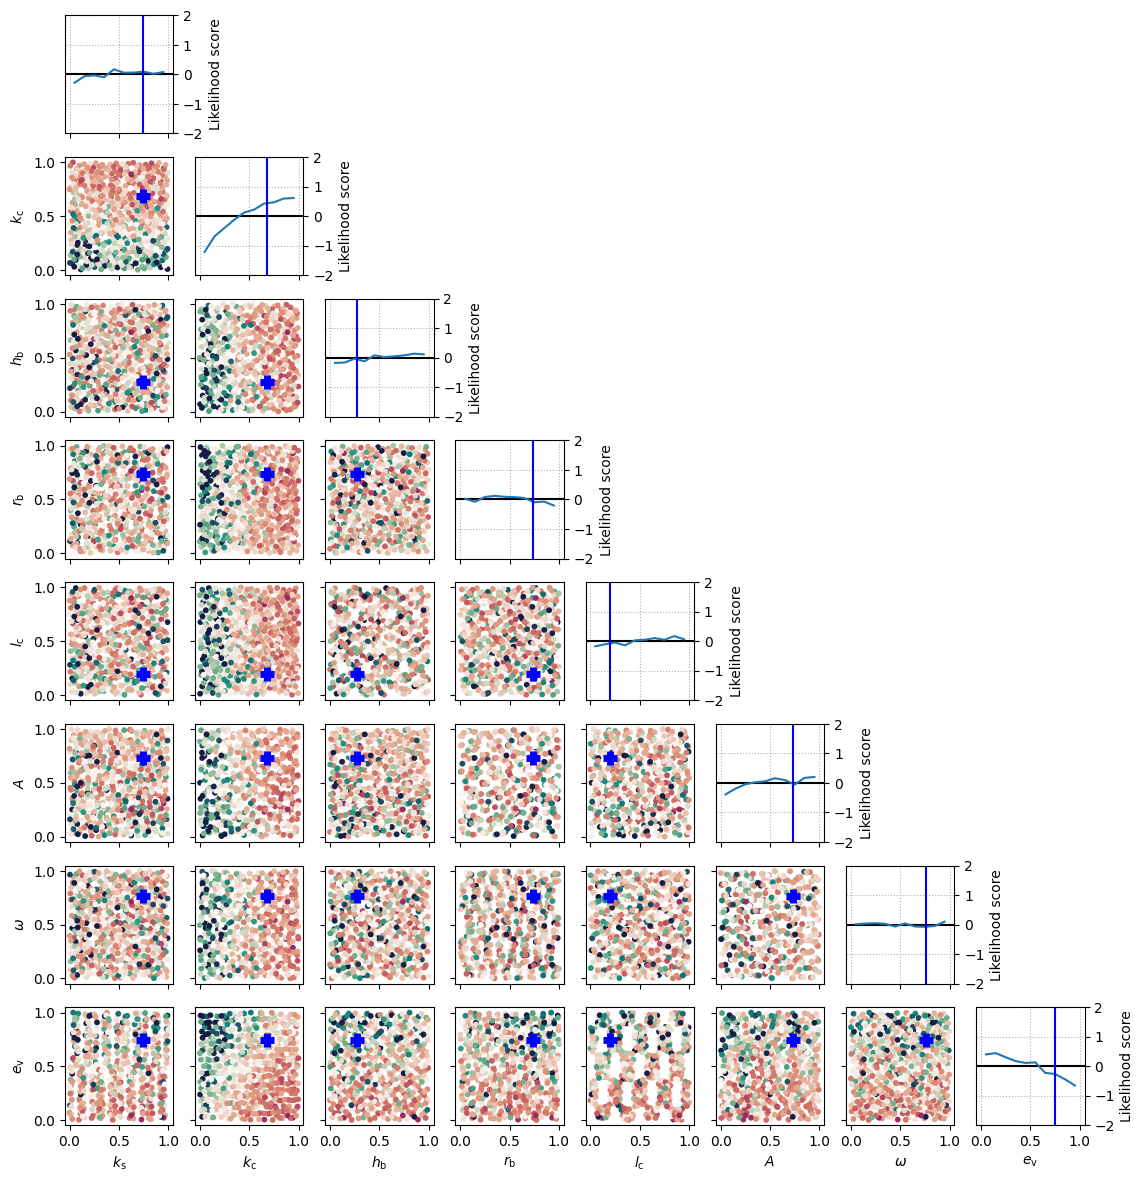

In [24]:
# t_sim = np.loadtxt('../issm/expdesign/greenland_train_standard.csv', delimiter=',', skiprows=1)[:m]
m = 512
t_names = np.loadtxt('../../expdesign/greenland_train_standard.csv', delimiter=',', max_rows=1, dtype=str)[:m]
fig,ax = plt.subplots(8,8,figsize=(12,12), sharex=True, sharey=False)
lmax = np.max(likeli)
dt = 0.1
thetas = np.arange(0, 1+dt, dt)
marginals = np.zeros((len(t_names), len(thetas)-1))
wi = W_train[-1][:, 10]
for i in range(len(t_names)):
    for j in range(len(thetas)-1):
        tmask = np.logical_and(t_sim[:,i]>=thetas[j], t_sim[:,i]<thetas[j+1])
#         print(len(np.where(tmask)[0]))
        wi = W_train[-1][:, 1]
        marginals[i, j] = np.mean(wi[tmask])

# marginals = marginals/np.vstack(np.sum(marginals*dt, axis=1))
        
for axi in ax.flat:
    axi.set_visible(False)
for row in range(8):
    for col in range(row):
        ax[row,col].set_visible(True)
        sc = ax[row,col].scatter(t_sim[:,col], t_sim[:,row], 10, wi, vmin=-2, vmax=2, cmap=cmocean.cm.curl)
#         ax[row,col].axvline(t_test[sim_num, col], color='b')
        ax[row,col].plot(t_test[sim_num,col], t_test[sim_num,row], 'b+',
            markersize=10, markeredgewidth=5)
        # print((row+1, col))
        if col==0:
            ax[row,col].set_ylabel(t_names[row])
        elif row!=col:
            ax[row,col].set_yticklabels([])
        if row==7:
            ax[row,col].set_xlabel(t_names[col])

    ax[row,row].set_visible(True)
    ax[row,row].axhline(0., color='k', label='prior')
    ax[row,row].plot(thetas[:-1] + 0.5*dt, marginals[row], label='posterior')
    # ax[row,row].set_ylim([0, 0.005])
    ax[row,row].set_ylim([-2, 2])
    ax[row,row].yaxis.tick_right()
    ax[row,row].yaxis.set_label_position('right')
    ax[row,row].set_ylabel('Likelihood score')
    ax[row,row].grid(linestyle=':')
    ax[row,row].set_xticks(np.linspace(0,1,3))
#     ax[row,row].plot(t_test)
    ax[row,row].axvline(t_test[sim_num, row], color='b')

ax[-1,-1].set_xlabel(t_names[-1])

plt.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.975)
# fig.savefig('likelihood_weighting_m512.png', dpi=300)
# fig.savefig('likelihood_weighting_prototype_para_dist_synthetic.png', dpi=300)